In [205]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#import json
from google.cloud import bigquery
from datetime import datetime,timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.ensemble import BalancedRandomForestClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_validate

from sklearn.metrics import classification_report


In [2]:
#Localisation du projet name et table_id sur gcp
project="marbotic"

In [3]:
#intégration des credentials 
from google.oauth2 import service_account

key_path = "/Users/antonin/code/AntoninAnq/gcp/marbotic-7d02fac30bd8.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

In [4]:
def extract(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT
    COUNT(DISTINCT ep.Activity_Name) as unique_activity, 
    sm.session_id,sum(Time_Spent) as Time_Spent,
    any_value(Action_Element_Name) as Action_Element_Name,
    any_value(Profile_Age_days) as Profile_Age_days,
    (SAFE_DIVIDE(SUM(event_type_Activity_Good_Answer) , (SUM(event_type_Activity_Good_Answer)
    + SUM(event_type_Activity_Wrong_Answer))))*100 as good_answer_ratio
    FROM `marbotic.marbotic_dataset.event_properties` as ep
    JOIN `marbotic.marbotic_dataset.sessions_metrics` as sm on ep.session_id = sm.session_id
    GROUP BY sm.session_id
    ORDER BY unique_activity DESC
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [5]:
#On récupère d'event le nombre d'activity unique par session, le ratio de bonne réponse par sessions et le time spent par sessions
first_data = extract(project,credentials)
first_data

,unique_activity,session_id,Time_Spent,Action_Element_Name,Profile_Age_days,good_answer_ratio
0,42,1.648054e+12,19329.0,Back,1899.0,100.0
1,41,1.646647e+12,21882.0,Back,8434.0,NaN
2,40,1.646297e+12,54083.0,Back,1968.0,100.0
3,39,1.647908e+12,9693.0,Back,2376.0,100.0
4,38,1.646244e+12,16048.0,Back,2227.0,100.0
...,...,...,...,...,...,...
18811,0,1.649895e+12,3621.0,None,NaN,NaN
18812,0,1.650056e+12,2552.0,None,NaN,NaN
18813,0,1.650073e+12,210.0,None,NaN,NaN
18814,0,1.650157e+12,1411.0,None,NaN,NaN


In [6]:
def extract_session_metrics(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT *
    FROM `marbotic.marbotic_dataset.sessions_metrics`
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [7]:
session_metrics_df = extract_session_metrics(project,credentials)
session_metrics_df

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear,session_start,game_events,setup_events
0,1.647421e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:14.214000+00:00,6,...,0.0,0.0,0.0,5.0,1.0,0.0,0.0,2022-03-16 08:56:40.722000+00:00,6.0,0.0
1,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:45.380000+00:00,5,...,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2022-03-16 08:58:28.269000+00:00,5.0,0.0
2,1.648134e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-24 15:06:35.838000+00:00,5,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2022-03-24 15:06:21.426000+00:00,5.0,0.0
3,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:57:59.845000+00:00,5,...,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2022-03-16 08:57:48.381000+00:00,5.0,0.0
4,1.646641e+12,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,2022-03-07 08:25:39.783000+00:00,6,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2022-03-07 08:24:40.937000+00:00,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.646491e+12,Notting Hill Gate,English,15.1,Royal Kensington and Chelsea,United Kingdom,iPad 6,1.0.7,2022-03-05 14:40:14.517000+00:00,5,...,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2022-03-05 14:39:48.894000+00:00,5.0,0.0
18812,1.652027e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 16:39:55.181000+00:00,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-08 16:32:21.326000+00:00,0.0,0.0
18813,1.652029e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 17:01:24.501000+00:00,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-08 16:58:54.378000+00:00,0.0,0.0
18814,1.652377e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-12 18:05:34.559000+00:00,19,...,0.0,0.0,0.0,10.0,4.0,0.0,0.0,2022-05-12 17:38:47.898000+00:00,19.0,0.0


In [8]:
#on merge les première colonnes crées avec la table sessions metrics
sm_df = session_metrics_df.merge(first_data, on='session_id')

In [9]:
#Calcul du temps de chaque session
sm_df['duration_min'] = (sm_df['session_end']-sm_df['session_start']).apply(lambda x: x.total_seconds()/60)

In [10]:
sm_df

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,event_type_Toast_Disappear,session_start,game_events,setup_events,unique_activity,Time_Spent,Action_Element_Name,Profile_Age_days,good_answer_ratio,duration_min
0,1.647421e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:14.214000+00:00,6,...,0.0,2022-03-16 08:56:40.722000+00:00,6.0,0.0,0,37.0,None,-1.0,NaN,1.558200
1,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:45.380000+00:00,5,...,0.0,2022-03-16 08:58:28.269000+00:00,5.0,0.0,0,25.0,None,-1.0,NaN,0.285183
2,1.648134e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-24 15:06:35.838000+00:00,5,...,0.0,2022-03-24 15:06:21.426000+00:00,5.0,0.0,0,28.0,None,-1.0,NaN,0.240200
3,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:57:59.845000+00:00,5,...,0.0,2022-03-16 08:57:48.381000+00:00,5.0,0.0,0,20.0,None,-1.0,NaN,0.191067
4,1.646641e+12,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,2022-03-07 08:25:39.783000+00:00,6,...,0.0,2022-03-07 08:24:40.937000+00:00,6.0,0.0,0,858.0,Back,1891.0,NaN,0.980767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.646491e+12,Notting Hill Gate,English,15.1,Royal Kensington and Chelsea,United Kingdom,iPad 6,1.0.7,2022-03-05 14:40:14.517000+00:00,5,...,0.0,2022-03-05 14:39:48.894000+00:00,5.0,0.0,0,31.0,None,-1.0,NaN,0.427050
18812,1.652027e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 16:39:55.181000+00:00,17,...,0.0,2022-05-08 16:32:21.326000+00:00,0.0,0.0,0,2525.0,None,4930.0,NaN,7.564250
18813,1.652029e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 17:01:24.501000+00:00,20,...,0.0,2022-05-08 16:58:54.378000+00:00,0.0,0.0,1,834.0,None,4930.0,NaN,2.502050
18814,1.652377e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-12 18:05:34.559000+00:00,19,...,0.0,2022-05-12 17:38:47.898000+00:00,19.0,0.0,1,9393.0,Back,4934.0,100.0,26.777683


In [11]:
def extract_user_metrics(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT user_creation_time, user_id
    FROM `marbotic.marbotic_dataset.users_metrics`
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [12]:
user_metrics_df = extract_user_metrics(project,credentials)

In [13]:
#on merge la date de création dans le cas ou on veut calculer la maturité du user au moment de la session. Non utilisé dans un premier temps
sm_df = sm_df.merge(user_metrics_df, on='user_id')

In [14]:
sm_df

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,session_start,game_events,setup_events,unique_activity,Time_Spent,Action_Element_Name,Profile_Age_days,good_answer_ratio,duration_min,user_creation_time
0,1.647421e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:14.214000+00:00,6,...,2022-03-16 08:56:40.722000+00:00,6.0,0.0,0,37.0,None,-1.0,NaN,1.558200,2021-11-20 15:17:18.537000+00:00
1,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:45.380000+00:00,5,...,2022-03-16 08:58:28.269000+00:00,5.0,0.0,0,25.0,None,-1.0,NaN,0.285183,2021-11-20 15:17:18.537000+00:00
2,1.648134e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-24 15:06:35.838000+00:00,5,...,2022-03-24 15:06:21.426000+00:00,5.0,0.0,0,28.0,None,-1.0,NaN,0.240200,2021-11-20 15:17:18.537000+00:00
3,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:57:59.845000+00:00,5,...,2022-03-16 08:57:48.381000+00:00,5.0,0.0,0,20.0,None,-1.0,NaN,0.191067,2021-11-20 15:17:18.537000+00:00
4,1.646641e+12,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,2022-03-07 08:25:39.783000+00:00,6,...,2022-03-07 08:24:40.937000+00:00,6.0,0.0,0,858.0,Back,1891.0,NaN,0.980767,2021-12-07 18:08:20.505000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.649501e+12,Kensington,English,15.1,Royal Kensington and Chelsea,United Kingdom,"iPad12,1",1.0.5,2022-04-09 10:45:26.022000+00:00,1,...,2022-04-09 10:45:26.022000+00:00,1.0,0.0,1,3573.0,None,NaN,NaN,0.000000,2021-12-19 14:16:39.549000+00:00
18812,1.652027e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 16:39:55.181000+00:00,17,...,2022-05-08 16:32:21.326000+00:00,0.0,0.0,0,2525.0,None,4930.0,NaN,7.564250,2022-05-08 16:29:14.356000+00:00
18813,1.652029e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 17:01:24.501000+00:00,20,...,2022-05-08 16:58:54.378000+00:00,0.0,0.0,1,834.0,None,4930.0,NaN,2.502050,2022-05-08 16:29:14.356000+00:00
18814,1.652377e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-12 18:05:34.559000+00:00,19,...,2022-05-12 17:38:47.898000+00:00,19.0,0.0,1,9393.0,Back,4934.0,100.0,26.777683,2022-05-08 16:29:14.356000+00:00


In [15]:
sm_df.columns

Index(['session_id', 'city', 'language', 'os_version', 'region', 'country',
       'device_model', 'start_version', 'session_end', 'id', 'user_id',
       'event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRedeem',
       'event_type_Action_ConversionClickSubscribe',
       'event_type_Activation_Game', 'event_type_Activation_New_Activation',
       'event_type_Activation_Piece', 'event_type_Activation_Product',
       'event_type_Activity_Good_Answer', 'event_type_Activity_Start',
       'event_type_Activity_Stop', 'event_type_Activity_Wrong_Answer',
       'event_type_Error_Error', 'event_type_Game_Pause',
       'event_type_Game_Start', 'event_type_Game_Stop',
       'event_type_OB_ClickStore', 'event_type_OB_ClickTrial',
       'event_type_OB_CommPreview', 'event_type_OB_DiscoverTrial',
  

In [16]:
#On calcul le nombre de sessions avant celle en cours
def nb_session(user_id,session_start):
    return sm_df[(sm_df['user_id']==user_id) & (sm_df['session_start']<session_start)].shape[0]

In [17]:
sm_df['previous_session'] = sm_df.apply(lambda x:nb_session(x.user_id,x.session_start), axis=1)

In [18]:
#On calcul le temps depuis la dernière sessions
def last_session_time(user_id,session_start):
    last_session = sm_df[(sm_df['user_id']==user_id) & (sm_df['session_start']<session_start)]\
    .sort_values(by='session_start',ascending=True)\
    .groupby('user_id').last()['session_start']
    if len(last_session.values)==0:
        return timedelta(0)
    else:
        last_session = last_session.dt.to_pydatetime()[0].replace(tzinfo=None)
        return (session_start.to_pydatetime().replace(tzinfo=None) - last_session)

In [19]:
#(sm_df[(sm_df['user_id']==65616.0) & (sm_df['session_start']<'2022-03-16 08:58:28.269000+00:00')].sort_values(by='session_start',ascending=True).groupby('user_id').last()['session_start'].dt.to_pydatetime()[0].replace(tzinfo=None))

In [20]:
sm_df['time_since_last_session'] = sm_df.apply(lambda x:last_session_time(x.user_id,x.session_start), axis=1)

In [21]:
#Vérification pour un utilisateur donné, le début de toutes ses sessions ordonné et l'écart avec la dernière session
sm_df[sm_df['user_id']==66337.0].sort_values(by='session_start',ascending=True)[['session_start','time_since_last_session']]

,session_start,time_since_last_session
10,2022-01-12 15:34:18.911000+00:00,0 days 00:00:00
11,2022-03-05 16:00:00.822000+00:00,52 days 00:25:41.911000
9,2022-03-05 20:23:34.583000+00:00,0 days 04:23:33.761000
6,2022-03-07 07:15:12.051000+00:00,1 days 10:51:37.468000
7,2022-03-07 07:52:31.465000+00:00,0 days 00:37:19.414000
4,2022-03-07 08:24:40.937000+00:00,0 days 00:32:09.472000
5,2022-05-09 09:50:43.882000+00:00,63 days 01:26:02.945000
8,2022-05-10 06:57:04.671000+00:00,0 days 21:06:20.789000
12,2022-05-10 14:45:39.525000+00:00,0 days 07:48:34.854000
16,2022-05-11 06:42:18.649000+00:00,0 days 15:56:39.124000


In [22]:
#sm_df.groupby('user_id').agg({'time_since_last_session':'mean','setup_events':sum,'game_events':sum,'id':'count'})['id'].value_counts()

In [23]:
#Durée moyenne entre deux sessions
sm_df[sm_df['time_since_last_session']!=timedelta(0)]['time_since_last_session'].mean()

Timedelta('3 days 04:41:50.486608937')

In [24]:
#Conversion de la colonne time_since_last_session timedelta en timestampe[min]
sm_df['time_since_last_session_min']=sm_df['time_since_last_session'].map(lambda x : x.total_seconds()/60)

**Ajout de la maturité au moment du début de la sessions**

In [25]:
sm_df["week_maturity"] =(sm_df["session_start"]-sm_df["user_creation_time"]).map(lambda x: int(np.ceil(x.days/7))+1)

**Ajout du type d'utilisateur depuis la table user_properties**

In [26]:
def extract_user_type(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT any_value(Type) as Type, user_id
    FROM `marbotic.marbotic_dataset.user_properties`
    GROUP BY user_id
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [27]:
user_type_df = extract_user_type(project,credentials)
user_type_df

,Type,user_id
0,Teacher,0
1,Parent,16640
2,Parent,65628
3,Teacher,70759
4,Parent,70772
...,...,...
2622,Parent,39339
2623,Parent,15023
2624,Parent,31008
2625,Teacher,44840


In [28]:
sm_df = sm_df.merge(user_type_df, on='user_id')

In [29]:
#Durée moyenne entre deux sessions pour les parents
sm_df[sm_df['Type']=='Parent'][sm_df['time_since_last_session']!=timedelta(0)]['time_since_last_session'].mean()

/var/folders/c7/kdqvz76x679f28lhd235r_v40000gn/T/ipykernel_96034/258057669.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sm_df[sm_df['Type']=='Parent'][sm_df['time_since_last_session']!=timedelta(0)]['time_since_last_session'].mean()


Timedelta('3 days 09:38:50.171011526')

In [30]:
week_maturity = sm_df['week_maturity']
min_last_session = sm_df['time_since_last_session_min']

In [31]:
sm_df['session_start_day'] = sm_df['session_start'].apply(lambda x: x.weekday()+1)

In [32]:
sm_df['session_start_month'] = sm_df['session_start'].apply(lambda x: x.month)

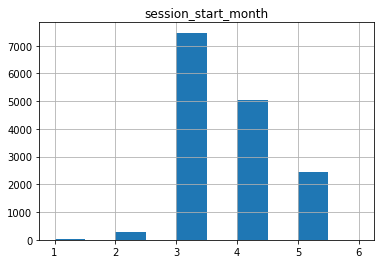

In [33]:
#Gros pic de session au mois de mars (= Merge de l'appli ? puis uniquement décroissance)
sm_df[sm_df['Type']=='Parent'][['session_start_month']].hist();

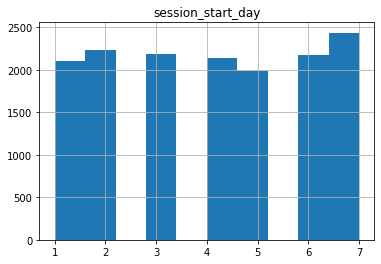

In [34]:
#On ne retrouve pas la saisonalité hebdomadaire annoncée
sm_df[sm_df['Type']=='Parent'][['session_start_day']].hist();

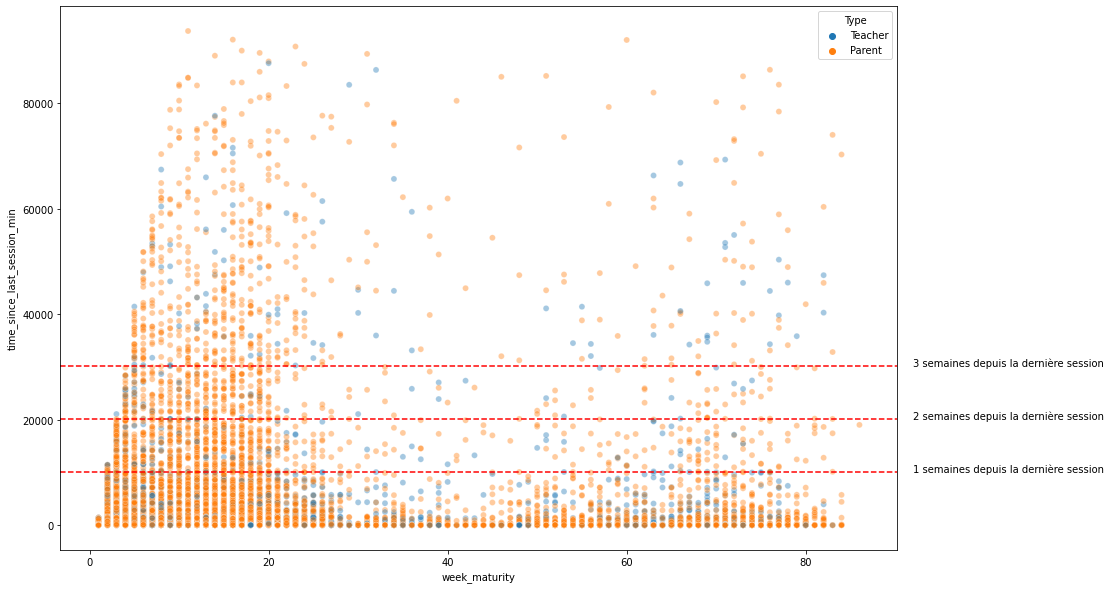

In [35]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x=week_maturity,y=min_last_session,alpha=0.4,hue=sm_df['Type'])

plt.axhline(30240, ls='--', linewidth=1.5, color='red')
plt.text(92,30240, "3 semaines depuis la dernière session")

plt.axhline(20160, ls='--', linewidth=1.5, color='red')
plt.text(92,20160, "2 semaines depuis la dernière session")

plt.axhline(10080, ls='--', linewidth=1.5, color='red')
plt.text(92,10080, "1 semaines depuis la dernière session")

plt.show()

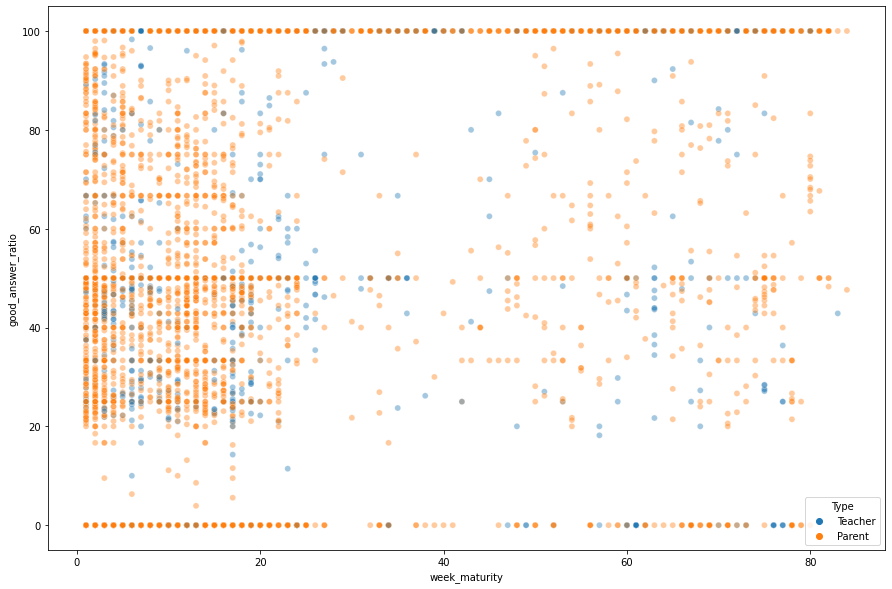

In [36]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x=week_maturity,y=sm_df['good_answer_ratio'],alpha=0.4,hue=sm_df['Type'])

#plt.axhline(30240, ls='--', linewidth=1.5, color='red')
#plt.text(92,30240, "3 semaines depuis la dernière session")

#plt.axhline(21160, ls='--', linewidth=1.5, color='red')
#plt.text(92,21160, "2 semaines depuis la dernière session")

#plt.axhline(10080, ls='--', linewidth=1.5, color='red')
#plt.text(92,10080, "1 semaines depuis la dernière session")
#plt.ylim(0,100)
plt.show()

In [37]:
#On drope la colone time_since_last_session en timedelta car incompatbile BQ
sm_df.drop('time_since_last_session',axis=1,inplace=True)

## Correlation

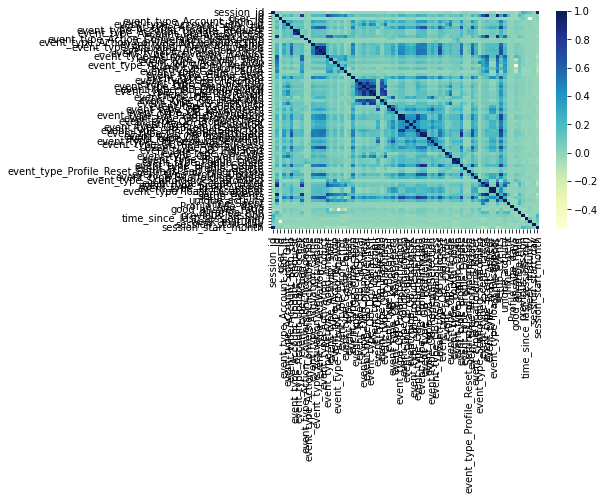

In [38]:
# Heatmap
corr = sm_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu");

In [39]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(20)

,feature_1,feature_2,correlation
4574,event_type_Toast_Disappear,event_type_Toast_Appear,0.990477
4501,event_type_Toast_Appear,event_type_Toast_Disappear,0.990477
2626,event_type_OB_ProductActivation,event_type_OB_ProductHelp,0.951273
2699,event_type_OB_ProductHelp,event_type_OB_ProductActivation,0.951273
4589,game_events,id,0.941049
136,id,game_events,0.941049
5402,session_start_month,session_id,0.934344
73,session_id,session_start_month,0.934344
4647,game_events,event_type_Scene_Leave,0.933703
4428,event_type_Scene_Leave,game_events,0.933703


In [40]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

/var/folders/c7/kdqvz76x679f28lhd235r_v40000gn/T/ipykernel_96034/4073438736.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


In [41]:
to_drop

['event_type_OB_ProductHelp',
 'event_type_OB_ProfileName',
 'event_type_Toast_Disappear',
 'game_events',
 'session_start_month']

## Labelling

In [379]:
#On considère le seuil de churn à 3 semaine.
#On est en situation de churn si la session suivante arrive dans plus de 3 semaines.
CHURN_THRESHOLD = timedelta(days=21)

#On utilise une constante TODAY pour evaluer le risque de churn des dernières session.
#Dans notre cas TODAY est le max de session end. On considère que l'extract s'arrète au moment de la dernière session de jeu dont on dispose
TODAY = datetime(2022, 5, 13, 0, 0)

In [380]:
#sm_df[(sm_df['user_id']==65616.0)& ('2022-03-16 08:58:14.214000+00:00'<sm_df['session_end'])].sort_values(by='session_end',ascending=True).groupby('user_id').first()['session_start']

In [381]:
#On calcul le temps jusqu'à la prochaine sessions si superieur au seuil de churn. Label_risque de churn = 1
def labelling_churn(user_id,session_end,session_start,CHURN_THRESHOLD,today):
    next_session = sm_df[(sm_df['user_id']==user_id) & (session_end<sm_df['session_end'])]\
    .sort_values(by='session_end',ascending=True)\
    .groupby('user_id').first()['session_start']
    if len(next_session.values) == 0:
        if today - session_start.to_pydatetime().replace(tzinfo=None)> CHURN_THRESHOLD :
            return 1
        else:
            return 0
    else:
        delta = (next_session - session_end)
        if delta.iloc[0] < CHURN_THRESHOLD:
            return 0
        else:
            return 1

In [382]:
sm_df['churn_risk'] = sm_df.apply(lambda x:labelling_churn(x.user_id,x.session_end,x.session_start,CHURN_THRESHOLD,TODAY), axis=1)

In [383]:
#Vérification du label de churn sur l'utilisateur déja vérifié plus haut.
sm_df[sm_df['user_id']==66337.0].sort_values(by='session_start',ascending=True)[['session_start','time_since_last_session_min','churn_risk']]

,session_start,time_since_last_session_min,churn_risk
10,2022-01-12 15:34:18.911000+00:00,0.000000,1
11,2022-03-05 16:00:00.822000+00:00,74905.698517,0
9,2022-03-05 20:23:34.583000+00:00,263.562683,0
6,2022-03-07 07:15:12.051000+00:00,2091.624467,0
7,2022-03-07 07:52:31.465000+00:00,37.323567,0
4,2022-03-07 08:24:40.937000+00:00,32.157867,1
5,2022-05-09 09:50:43.882000+00:00,90806.049083,0
8,2022-05-10 06:57:04.671000+00:00,1266.346483,0
12,2022-05-10 14:45:39.525000+00:00,468.580900,0
16,2022-05-11 06:42:18.649000+00:00,956.652067,0


In [384]:
sm_df[sm_df['Type']=='Parent']['churn_risk'].value_counts()

0    13330
1     1911
Name: churn_risk, dtype: int64

In [385]:
(1901/(13090+1901))*100

12.680941898472417

In [386]:
sm_df[sm_df['Type']=='Teacher']['churn_risk'].value_counts()

0    3252
1     319
Name: churn_risk, dtype: int64

In [387]:
(329/(329+3495))*100

8.603556485355648

## Cleaning

In [388]:
#No duplicates
sm_df.duplicated().sum()

0

In [389]:
((sm_df.isnull().sum().sort_values(ascending=False)/len(sm_df))*100).head(10)

session_id                                           0.0
event_type_OB_Success                                0.0
event_type_Profile_Reset_Settings_and_Progression    0.0
event_type_Profile_Delete                            0.0
event_type_Profile_Create                            0.0
event_type_Popup_Open                                0.0
event_type_Popup_Close                               0.0
event_type_OB_VerifCode                              0.0
event_type_OB_Type                                   0.0
event_type_OB_TrialStart                             0.0
dtype: float64

good_answer_ratio Nan correspond to session with no event type answer. On remplace les Nan par -1

In [390]:
answer_ratio_imputer = SimpleImputer(strategy='constant',fill_value=-1)
sm_df['good_answer_ratio'] = answer_ratio_imputer.fit_transform(sm_df[['good_answer_ratio']])

In [391]:
#34% de Nan, on drop cette colonne tant qu'on n'a pas d'information supplémentaire sur la signification des Nan
sm_df['Action_Element_Name'].value_counts()

KeyError: 'Action_Element_Name'

In [392]:
sm_df.drop('Action_Element_Name',axis=1,inplace=True)

KeyError: "['Action_Element_Name'] not found in axis"

In [393]:
#Pour Profile_Age_days(17%), Time_Spent(0.03) on remplace par la médiane car un énorme outlier(-2911184.0) et 3341 valeur = -1
med_imputer = SimpleImputer(strategy='median')
sm_df['Profile_Age_days'] = med_imputer.fit_transform(sm_df[['Profile_Age_days']])
sm_df['Time_Spent'] = med_imputer.fit_transform(sm_df[['Time_Spent']])

In [394]:
#Pour Type, il manque une valeur on remplace par most frequent
mmost_freq_imputer = SimpleImputer(missing_values=None,strategy='most_frequent')
sm_df['Type'] = mmost_freq_imputer.fit_transform(sm_df[['Type']])

In [395]:
((sm_df.isnull().sum().sort_values(ascending=False)/len(sm_df))*100).head(10)

session_id                                           0.0
event_type_OB_Success                                0.0
event_type_Profile_Reset_Settings_and_Progression    0.0
event_type_Profile_Delete                            0.0
event_type_Profile_Create                            0.0
event_type_Popup_Open                                0.0
event_type_Popup_Close                               0.0
event_type_OB_VerifCode                              0.0
event_type_OB_Type                                   0.0
event_type_OB_TrialStart                             0.0
dtype: float64

**Traitement des outliers extremes**

In [396]:
# A controle Time_spent max, Profile_Age_days min
#On supprime la session avec le time_spent = 17162486.0 de user_id = 23370.0 
#Il a 70 sessions avec une médiane de Time_spent 7571
sm_df[['Time_Spent']].max()

Time_Spent    837348.0
dtype: float64

In [397]:
sm_df.shape

(18812, 86)

In [398]:
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==17162486.0].index,inplace=True)

In [399]:
#On supprime 2 autres lignes avec Time_Spent > 1 000 000 Cela concerne le même utilsateur qui a 20 sessions
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==2190329.0].index,inplace=True)
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==1093473.0].index,inplace=True)

In [400]:
# On supprime l'utilisateur avec un age énorme négatif. Session unique user_creation_time : 27-22-2021
sm_df.drop(axis=0,index=sm_df[sm_df['Profile_Age_days']==-2911184.0].index,inplace=True)

## processing des colonnes

In [401]:
sm_df.select_dtypes(include='object')

,city,language,os_version,region,country,device_model,start_version,Type
0,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,Teacher
1,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,Teacher
2,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,Teacher
3,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,Teacher
4,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,Parent
...,...,...,...,...,...,...,...,...
18811,Kensington,English,15.1,Royal Kensington and Chelsea,United Kingdom,"iPad12,1",1.0.5,Parent
18812,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,Parent
18813,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,Parent
18814,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,Parent


In [402]:
class CustomOHE(OneHotEncoder):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

In [403]:
cat_transformer = CustomOHE(sparse = False, handle_unknown = "ignore", drop='if_binary')
cat_selection = sm_df[['Type']].columns

In [404]:
class CustomMinMaxScale(MinMaxScaler):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

In [405]:
#On retire des éléments très corrélés
num_transformer = CustomMinMaxScale()
num_selection = sm_df.select_dtypes(include=['float64','int64']).drop(['churn_risk','session_id','id','user_id','event_type_Toast_Disappear','event_type_OB_ProductHelp','event_type_OB_ProfileName'],axis=1).columns

In [406]:
class Cyclical_month_Encoder(BaseEstimator, TransformerMixin):
    '''Custom transformer to convert month into cyclical encoding cos and sin'''
    def _init_(self):
        pass 
    
    def fit(self, X,y=None):
        return super().fit(*args, **kwargs) 
    
    def transform(self, X,y=None):
        X = pd.DataFrame(X)
        df = pd.DataFrame()
        cst = (2*np.pi/12)
        df['month_cos'] = X.apply(lambda x: np.cos(cst*x))
        df['month_sin'] = X.apply(lambda x: np.sin(cst*x))
        return df
    
    def fit_transform(self, X,y=None):
        X = pd.DataFrame(X)
        df = pd.DataFrame()
        cst = (2*np.pi/12)
        df['month_cos'] = X.apply(lambda x: np.cos(cst*x))
        df['month_sin'] = X.apply(lambda x: np.sin(cst*x))
        return df
    
    def get_feature_names_out(self,X):
        return 'month_cos','month_sin'

In [407]:
month_transformer = Cyclical_month_Encoder()
month_selection = sm_df[['session_start_month']].columns

In [408]:
class Cyclical_day_Encoder(BaseEstimator, TransformerMixin):
    '''Custom transformer to convert day into cyclical encoding cos and sin'''
    def _init_(self):
        pass 
    
    def fit(self, X,y=None):
        return self
    
    def transform(self, X,y=None):
        X = pd.DataFrame(X)
        df = pd.DataFrame()
        cst = (2*np.pi/7)
        df['day_cos'] = X.apply(lambda x: np.cos(cst*x))
        df['day_sin'] = X.apply(lambda x: np.sin(cst*x))
        return df
    
    def get_feature_names_out(self,X):
        return 'day_cos','day_sin'

In [409]:
day_transformer = Cyclical_day_Encoder()
day_selection = sm_df[['session_start_day']].columns

In [410]:
class CustomColumnTransformer(ColumnTransformer):
    
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs)
    
    def transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().transform(X, *args, **kwargs), columns=self.get_feature_names_out())
    
    def fit_transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(X, *args, **kwargs), columns=self.get_feature_names_out())

In [411]:
preprocessor = CustomColumnTransformer([
    ('num_tr',num_transformer,num_selection),
    ('cat_tr',cat_transformer,cat_selection ),
    ('month_tr',month_transformer,month_selection ),
    ('day_tr',day_transformer,day_selection )],
    remainder = 'drop'
)

In [412]:
preprocessor

CustomColumnTransformer(transformers=[('num_tr', CustomMinMaxScale(),
                                       Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRedeem',
       'event_type_Action_ConversionClickSubscribe',
       'e...
       'time_since_last_session_min', 'week_maturity', 'session_start_day',
       'session_start_month'],
      dtype='object')),
                                      ('cat_tr',
                                       CustomOHE(drop='if_binary',
                                                 handle_unknown='ignore',
                                                 sparse=False),
                                       Index(['Type'], dtype='object')),
                                      ('month_tr', Cyclical_month_Encoder(),
                                       Index(['session_start_month'], dtype='object')),
                                      ('day_tr', Cyclical_day_Encoder(),
                                       Index(['session_start_day'], dtype='object'))])

In [413]:
sm_df['churn_risk'].value_counts()

0    16582
1     2230
Name: churn_risk, dtype: int64

## Preparation du jeu de donnée

**On downsample les sessions sans churn risque pour en avoir autant que de churn risque**

In [414]:
#def downsample_churn_risk(df):
#    sm_df_churn_risque = df[df['churn_risk']==1]
#    sm_df_no_churn_risque = df[df['churn_risk']==0]
#    sm_df_no_churn_risque = sm_df_no_churn_risque.loc\
#    [np.random.choice(sm_df_no_churn_risque.index,size = sm_df_churn_risque.shape[0])]
#    
#    sm_df_balanced = pd.concat([sm_df_no_churn_risque,sm_df_churn_risque],axis=0)
#    X= sm_df_balanced.drop('churn_risk',axis=1).copy()
#    y = sm_df_balanced['churn_risk'].copy()
#    return X,y

In [415]:
#X,y = downsample_churn_risk(sm_df)

**On upsample dans le pipe sur le X_train uniquement**

In [416]:
X = sm_df.drop('churn_risk',axis=1).copy()
y = sm_df['churn_risk'].copy()

In [417]:
X.shape,y.shape

((18812, 85), (18812,))

In [418]:
y.value_counts()

0    16582
1     2230
Name: churn_risk, dtype: int64

On sépare le jeu de donnée en train et test

In [419]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Model

In [420]:
class CustomSelectPercentile(SelectPercentile):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

In [421]:
smote_pipe = Pipeline([('prep',preprocessor),\
                       ('feat_selec',CustomSelectPercentile(percentile=50)),\
                       ('RF',BalancedRandomForestClassifier())])

In [596]:
smote_pipe

Pipeline(steps=[('prep',
                 CustomColumnTransformer(transformers=[('num_tr',
                                                        CustomMinMaxScale(),
                                                        Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRedeem',
       'event_type_Action_Conv...
                                                        CustomOHE(drop='if_binary',
                                                                  handle_unknown='ignore',
                                                                  sparse=False),
                                                        Index(['Type'], dtype='object')),
                                                       ('month_tr',
                                                        Cyclical_month_Encoder(),
                                                        Index(['session_start_month'], dtype='object')),
                                                       ('day_tr',
                                                        Cyclical_day_Encoder(),
                                                        Index(['session_start_day'], dtype='object'))])),
                ('feat_selec', CustomSelectPercentile(percentile=50)),
                ('RF', BalancedRandomForestClassifier())])

In [422]:
smote_pipe.get_params()

{'memory': None,
 'steps': [('prep',
   CustomColumnTransformer(transformers=[('num_tr', CustomMinMaxScale(),
                                          Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
          'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
          'event_type_Account_Update_Success', 'event_type_Action_Click',
          'event_type_Action_ConversionClickRedeem',
          'event_type_Action_ConversionClickSubscribe',
          'e...
          'time_since_last_session_min', 'week_maturity', 'session_start_day',
          'session_start_month'],
         dtype='object')),
                                         ('cat_tr',
                                          CustomOHE(drop='if_binary',
                                                    handle_unknown='ignore',
                                                    sparse=False),
                                          Index(['Type'], dtype='object')),
                      

In [611]:
grid_search = GridSearchCV(
    smote_pipe, 
    param_grid={
        'RF__max_depth': [60],
        'RF__class_weight' : ['balanced'],
        'RF__min_samples_split' : [20],
        'RF__n_estimators' : [60],
        'RF__max_samples' : [0.75],
        'RF__n_jobs' : [-1],
    },
    cv=5,
    scoring='recall',
verbose=1)

In [612]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'RF__class_weight': 'balanced',
 'RF__max_depth': 60,
 'RF__max_samples': 0.75,
 'RF__min_samples_split': 20,
 'RF__n_estimators': 60,
 'RF__n_jobs': -1}

In [613]:
grid_search.best_score_

0.9371424064982946

In [614]:
best_search = grid_search.best_estimator_

In [615]:
#Predicting with oversample X_test
y_pred = best_search.predict(X_test)

In [616]:
target_names = ['classe 0','Classe 1']
print(classification_report(y_test,y_pred,target_names=target_names))

              precision    recall  f1-score   support

    classe 0       0.99      0.48      0.64      5005
    Classe 1       0.19      0.96      0.32       639

    accuracy                           0.53      5644
   macro avg       0.59      0.72      0.48      5644
weighted avg       0.90      0.53      0.61      5644



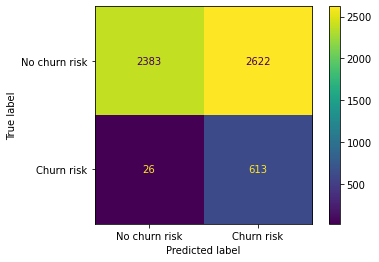

In [617]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label = ['No churn risk', 'Churn risk'] 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label)
disp.plot();

In [618]:
#Random forest nous donne l'importance des features qui ont été gardé pour le modèle. La somme de tous les scores des features gardées fait 1.
dict_feature = {}
for name, score in zip(best_search.named_steps["RF"].feature_names_in_, best_search.named_steps['RF'].feature_importances_):
    dict_feature[name]= score
pd.DataFrame.from_dict(dict_feature, orient='index').sort_values(by=0,ascending=False)

,0
num_tr__previous_session,0.188658
month_tr__month_cos,0.112285
num_tr__session_start_month,0.097270
num_tr__time_since_last_session_min,0.081596
num_tr__Time_Spent,0.060009
num_tr__game_events,0.047580
num_tr__duration_min,0.046101
month_tr__month_sin,0.041017
num_tr__week_maturity,0.039139
num_tr__event_type_Scene_Enter,0.033305


In [619]:
#Analyse de la variance des colonnes gardées
pd.DataFrame(best_search.named_steps["feat_selec"].scores_,index=best_search.named_steps["feat_selec"].feature_names_in_).sort_values(by=0,ascending=False)[:33]

,0
num_tr__previous_session,379.864577
num_tr__session_start_month,224.893074
month_tr__month_sin,216.545461
month_tr__month_cos,190.634649
num_tr__week_maturity,58.693931
num_tr__time_since_last_session_min,45.640943
num_tr__Time_Spent,29.774454
num_tr__unique_activity,26.725583
num_tr__game_events,22.117455
num_tr__event_type_Action_Click,21.772297


## Tentative de stacking ##

In [432]:
ran_for_C = RandomForestClassifier(max_depth=40,max_samples= 0.8,min_samples_split= 15, n_estimators=450,class_weight='balanced_subsample')
log_reg_C = LogisticRegression(max_iter = 1000,n_jobs=-1, C= 1.5,solver= 'newton-cg')
svc_C = SVC(C= 10,gamma= 1,kernel= 'rbf')
knn_C = KNeighborsClassifier(n_jobs= -1,n_neighbors= 30,p= 1,weights= 'distance')
ada_b_C = AdaBoostClassifier(algorithm= 'SAMME.R',learning_rate= 1,n_estimators= 50)
ridge_C = RidgeClassifier(alpha= 2,max_iter= 1000,solver= 'lsqr')

ensemble = StackingClassifier(
    estimators = [("rf", ran_for_C),
                  ("knn", knn_C),
                  ('log',log_reg_C),
                  ('svc',svc_C),
                  ('ada',ada_b_C),
                  ('ridge',ridge_C)
                 ],
    final_estimator = GradientBoostingClassifier())
stacked_pipe = Pipeline([('prep',preprocessor),\
                         ('under_sample',RandomUnderSampler()),\
                       ('feat_selec',CustomSelectPercentile(percentile=50)),\
                       ('ensemble_stack',ensemble)])

In [433]:
cv_results_stacked = cross_validate(stacked_pipe, X_train, y_train, scoring='recall', cv=5)

/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [48] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8

In [434]:
score_stacked = cv_results_stacked['test_score'].mean()
score_stacked

0.8089252972141716

In [435]:
stacked_pipe.fit(X_train, y_train)

/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [48] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(steps=[('prep',
                 CustomColumnTransformer(transformers=[('num_tr',
                                                        CustomMinMaxScale(),
                                                        Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRedeem',
       'event_type_Action_Conv...
                                                                        n_estimators=450)),
                                                ('knn',
                                                 KNeighborsClassifier(n_jobs=-1,
                                                                      n_neighbors=30,
                                                                      p=1,
                                                                      weights='distance')),
                                                ('log',
                                                 LogisticRegression(C=1.5,
                                                                    max_iter=1000,
                                                                    n_jobs=-1,
                                                                    solver='newton-cg')),
                                                ('svc', SVC(C=10, gamma=1)),
                                                ('ada',
                                                 AdaBoostClassifier(learning_rate=1)),
                                                ('ridge',
                                                 RidgeClassifier(alpha=2,
                                                                 max_iter=1000,
                                                                 solver='lsqr'))],
                                    final_estimator=GradientBoostingClassifier()))])

In [436]:
y_pred_stacked = stacked_pipe.predict(X_test)

In [437]:
print(classification_report(y_test,y_pred_stacked,target_names=target_names))

              precision    recall  f1-score   support

    classe 0       0.96      0.67      0.79      5005
    Classe 1       0.24      0.81      0.37       639

    accuracy                           0.69      5644
   macro avg       0.60      0.74      0.58      5644
weighted avg       0.88      0.69      0.74      5644



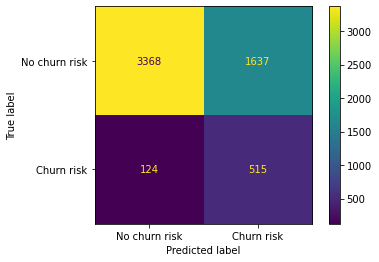

In [438]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label = ['No churn risk', 'Churn risk'] 
cm = confusion_matrix(y_test, y_pred_stacked)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label)
disp.plot();

In [439]:
stacked_pipe.named_steps.keys()

dict_keys(['prep', 'under_sample', 'feat_selec', 'ensemble_stack'])

In [440]:
#Analyse de la variance des colonnes gardées
pd.DataFrame(stacked_pipe.named_steps["feat_selec"].scores_,index=stacked_pipe.named_steps["feat_selec"].feature_names_in_).sort_values(by=0,ascending=False)[:33]

,0
num_tr__previous_session,430.325860
month_tr__month_sin,191.856509
num_tr__session_start_month,160.367708
month_tr__month_cos,129.499020
num_tr__week_maturity,37.865310
num_tr__duration_min,27.660675
num_tr__time_since_last_session_min,27.589933
num_tr__game_events,23.130093
num_tr__unique_activity,20.710015
num_tr__Time_Spent,20.390988


**Quels sont les colonnes qui ont été gardée dans le modèle de stacking**

In [441]:
columns_selected_pipe = make_pipeline(preprocessor,CustomSelectPercentile(percentile=50))
columns_selected = columns_selected_pipe.fit_transform(X_train, y_train).columns

In [442]:
columns_selected = [f[8:] for f in columns_selected]

In [443]:
#33 colonnes gardées
columns_selected

['event_type_Account_Sign_Up',
 'event_type_Action_Click',
 'event_type_Action_ConversionClickRedeem',
 'event_type_Activation_New_Activation',
 'event_type_Activation_Piece',
 'event_type_Activation_Product',
 'event_type_Activity_Good_Answer',
 'event_type_Activity_Start',
 'event_type_Activity_Stop',
 'event_type_Activity_Wrong_Answer',
 'event_type_Error_Error',
 'event_type_Game_Pause',
 'event_type_OB_CommPreview',
 'event_type_OB_DoYouHaveKit',
 'event_type_OB_Email',
 'event_type_OB_HasKitYes',
 'event_type_OB_Success',
 'event_type_OB_VerifCode',
 'event_type_Profile_Update',
 'event_type_Scaffolding_Scaffolding',
 'event_type_Scene_Enter',
 'event_type_Scene_Leave',
 'game_events',
 'unique_activity',
 'Time_Spent',
 'good_answer_ratio',
 'duration_min',
 'previous_session',
 'time_since_last_session_min',
 'week_maturity',
 'session_start_day',
 'session_start_month',
 'Type_Teacher',
 '__month_cos',
 '__month_sin',
 'day_sin']

## Modèle uniquement sur les parents

In [444]:
parent_df = sm_df[sm_df['Type']=="Parent"]

In [445]:
X_parent = parent_df.drop('churn_risk',axis=1).copy()
y_parent = parent_df['churn_risk'].copy()

In [446]:
X_train_parent, X_test_parent, y_train_parent, y_test_parent = train_test_split(X_parent, y_parent, test_size=0.30)

In [447]:
grid_search.fit(X_train_parent, y_train_parent)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [68] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [68] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        CustomColumnTransformer(transformers=[('num_tr',
                                                                               CustomMinMaxScale(),
                                                                               Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRed...
                                                                               Index(['session_start_month'], dtype='object')),
                                                                              ('day_tr',
                                                                               Cyclical_day_Encoder(),
                                                                               Index(['session_start_day'], dtype='object'))])),
                                       ('feat_selec',
                                        CustomSelectPercentile(percentile=50)),
                                       ('RF',
                                        BalancedRandomForestClassifier())]),
             param_grid={'RF__class_weight': ['balanced'],
                         'RF__max_depth': [40], 'RF__max_samples': [0.8],
                         'RF__min_samples_split': [15], 'RF__n_jobs': [-1]},
             scoring='recall', verbose=1)

In [448]:
grid_search.best_params_
best_search_parent = grid_search.best_estimator_

In [449]:
y_pred_parent_stacked = best_search_parent.predict(X_test_parent)

In [450]:
print(classification_report(y_test_parent,y_pred_parent_stacked,target_names=target_names))

              precision    recall  f1-score   support

    classe 0       0.98      0.48      0.64      3996
    Classe 1       0.21      0.93      0.34       577

    accuracy                           0.54      4573
   macro avg       0.59      0.71      0.49      4573
weighted avg       0.88      0.54      0.60      4573



## Modèle uniquement sur les clients récents ?

In [451]:
sm_df['user_creation_time'] = sm_df["user_creation_time"].map(lambda x: x.to_pydatetime())
sm_df["user_creation_time"]=sm_df["user_creation_time"].map(lambda x: x.replace(tzinfo=None))

In [452]:
sm_df_reduced = sm_df[sm_df['user_creation_time']>datetime(2022, 1, 1, 0, 0)]

In [453]:
X_reduced = sm_df_reduced.drop('churn_risk',axis=1).copy()
y_reduced = sm_df_reduced['churn_risk'].copy()


In [454]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.30)

In [455]:
grid_search.fit(X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        CustomColumnTransformer(transformers=[('num_tr',
                                                                               CustomMinMaxScale(),
                                                                               Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRed...
                                                                               Index(['session_start_month'], dtype='object')),
                                                                              ('day_tr',
                                                                               Cyclical_day_Encoder(),
                                                                               Index(['session_start_day'], dtype='object'))])),
                                       ('feat_selec',
                                        CustomSelectPercentile(percentile=50)),
                                       ('RF',
                                        BalancedRandomForestClassifier())]),
             param_grid={'RF__class_weight': ['balanced'],
                         'RF__max_depth': [40], 'RF__max_samples': [0.8],
                         'RF__min_samples_split': [15], 'RF__n_jobs': [-1]},
             scoring='recall', verbose=1)

In [456]:
grid_search.best_params_
best_search_reduced = grid_search.best_estimator_

In [457]:
y_pred_reduced_stacked = best_search_reduced.predict(X_test_reduced)

In [458]:
print(classification_report(y_test_reduced,y_pred_reduced_stacked,target_names=target_names))

              precision    recall  f1-score   support

    classe 0       0.98      0.47      0.64      2953
    Classe 1       0.17      0.93      0.28       339

    accuracy                           0.52      3292
   macro avg       0.58      0.70      0.46      3292
weighted avg       0.90      0.52      0.60      3292



## Upload dans BQ

**Upload de la table en cours dans BQ**

In [459]:
###Localisation du projet name et table_id sur gcp
#project="marbotic"
#table_id = "marbotic_dataset.session_augmented"
#client = bigquery.Client(project,credentials)
#
#job = client.load_table_from_dataframe(sm_df, table_id) 
#
#job.result()  # Wait for the job to complete.
#table = client.get_table(table_id)  # Make an API request.
#print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), table_id))